In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib_inline.backend_inline as backend_inline
from torchsummary import summary

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [4]:
# Create the Dataset
nPerClass = 5500  # Number of samples per class
imgSize = 91  # Image size (91x91)

x = np.linspace(-4, 4, imgSize)
# print("x.shape:", x.shape)
X, Y = np.meshgrid(x, x)
# print("X.shape:", X.shape, "Y.shape:", Y.shape)
# print(Y)
# The Two widths (Arbetary Units)
widths = [1.8, 2.4]

# Initialize tensors containing images and labels
images = torch.zeros(2 * nPerClass, 1, imgSize, imgSize)  # Zeros in the right shape
labels = torch.zeros(2 * nPerClass)  # Zeros in the right shape

# Generate the images

for i in range(2 * nPerClass):
    # Create the gaussian with random center
    ro = 2 * np.random.randn(2)  # ro = randome offset
    G = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * widths[i % 2] ** 2))

    # Add the noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # Add to tensor
    images[i, :, :, :] = torch.tensor(G).view(1, imgSize, imgSize)
    labels[i] = i % 2

labels = labels.reshape(-1, 1)  # Reshape labels to be a column vector
print("images.shape:", images.shape, "labels.shape:", labels.shape)

images.shape: torch.Size([11000, 1, 91, 91]) labels.shape: torch.Size([11000, 1])


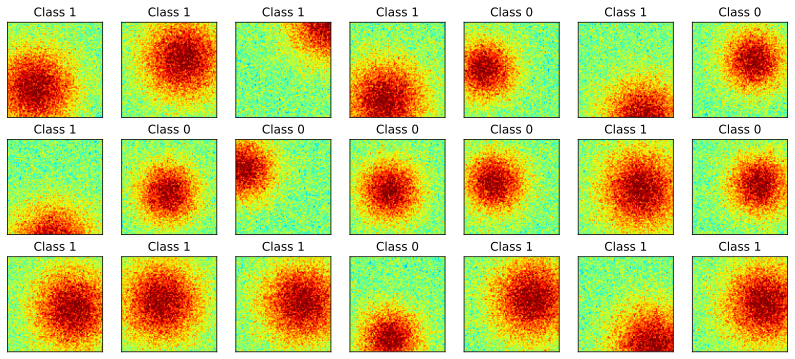

In [5]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(14, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2 * nPerClass)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    ax.set_title("Class %s" % int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [6]:
# Create train/test groups using Dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, train_size=0.8
)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

# Print the shapes of the datasets
print(
    "Train Data Shape:",
    train_data.tensors[0].shape,
    "\nTrain Labels Shape:",
    train_data.tensors[1].shape,
    "\n============================================",
)
print(
    "Test Data Shape:",
    test_data.tensors[0].shape,
    "\nTest Labels Shape:",
    test_data.tensors[1].shape,
)

Train Data Shape: torch.Size([8800, 1, 91, 91]) 
Train Labels Shape: torch.Size([8800, 1]) 
Test Data Shape: torch.Size([2200, 1, 91, 91]) 
Test Labels Shape: torch.Size([2200, 1])


In [7]:
# Create CNN Model
def create_cnn_model():
    class gausnet(nn.Module):

        def __init__(self):
            super().__init__()
            self.enc = nn.Sequential(
                nn.Conv2d(
                    1, 4, 3, padding=1
                ),  # Input channels = 1, Output channels = 6, Kernel size = 3 => ((91 + 2*1 - 3) / 1) + 1 = 91
                nn.ReLU(),
                nn.AvgPool2d(
                    2, 2
                ),  # Kernel size = 2, Stride = 2 => ((91 - 2) / 2) + 1 = 45.5 => 45 (integer division)
                nn.Conv2d(
                    4, 6, 3, padding=1
                ),  # Input channels = 6, Output channels = 4, Kernel size = 3 => ((45 + 2*1 - 3) / 1) + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(
                    2, 2
                ),  # Kernel size = 2, Stride = 2 => ((45 - 2) / 2) + 1 = 22.5 => 22 (integer division)
                nn.Flatten(),
                nn.Linear(
                    6 * 22 * 22, 100
                ),  # Input features = 4 * 22 * 22 = 1936, Output features = 50
                nn.Linear(100, 50),
                nn.Linear(50, 1),  # Input features = 50, Output features = 1
            )

        def forward(self, x):
            return self.enc(x)

    # Create the model instance
    net = gausnet()

    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

    return net, lossFun, optimizer

In [8]:
net, lossFun, optimizer = create_cnn_model()

X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(" ")
print(yHat.shape)

# # now let's compute the loss
loss = lossFun(yHat, y)
print(" ")
print("Loss:")
print(loss)

 
torch.Size([32, 1])
 
Loss:
tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [9]:
summary(net, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 4, 91, 91]           40
|    └─ReLU: 2-2                         [-1, 4, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 4, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 6, 45, 45]           222
|    └─ReLU: 2-5                         [-1, 6, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 6, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 2904]                --
|    └─Linear: 2-8                       [-1, 100]                 290,500
|    └─Linear: 2-9                       [-1, 50]                  5,050
|    └─Linear: 2-10                      [-1, 1]                   51
Total params: 295,863
Trainable params: 295,863
Non-trainable params: 0
Total mult-adds (M): 1.33
Input size (MB): 0.03
Forward/backward pass size

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 4, 91, 91]           40
|    └─ReLU: 2-2                         [-1, 4, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 4, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 6, 45, 45]           222
|    └─ReLU: 2-5                         [-1, 6, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 6, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 2904]                --
|    └─Linear: 2-8                       [-1, 100]                 290,500
|    └─Linear: 2-9                       [-1, 50]                  5,050
|    └─Linear: 2-10                      [-1, 1]                   51
Total params: 295,863
Trainable params: 295,863
Non-trainable params: 0
Total mult-adds (M): 1.33
Input size (MB): 0.03
Forward/backward pass size

In [10]:
# Function to train the model


def train_the_model(train_loader, test_loader, epochs=10):
    # Create the model
    net, lossFun, optimizer = create_cnn_model()

    # Initialize lists to store losses
    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainAcc = torch.zeros(epochs)
    testAcc = torch.zeros(epochs)

    # Training loop
    for epoch in range(epochs):
        # print(f"Epoch {epoch + 1}/{epochs}")
        net.train()

        # Batch training
        batchLoss = []
        batchAcc = []
        for X, y in train_loader:
            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and Accuracy
            batchLoss.append(loss.cpu().item())
            batchAcc.append(torch.mean((((yHat > 0) == y).float())).cpu().item())
        # End of batch training
        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100 * np.mean(batchAcc)

        # Test Loss and Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossFun(yHat, y)
        testLoss[epoch] = loss.cpu().item()
        testAcc[epoch] = 100 * torch.mean(((yHat > 0) == y).float()).cpu().item()
        # End of epoch

    # Function output
    return net, trainLoss, testLoss, trainAcc, testAcc

In [11]:
# Train the model
net, trainLoss, testLoss, trainAcc, testAcc = train_the_model(
    train_loader, test_loader, epochs=35
)

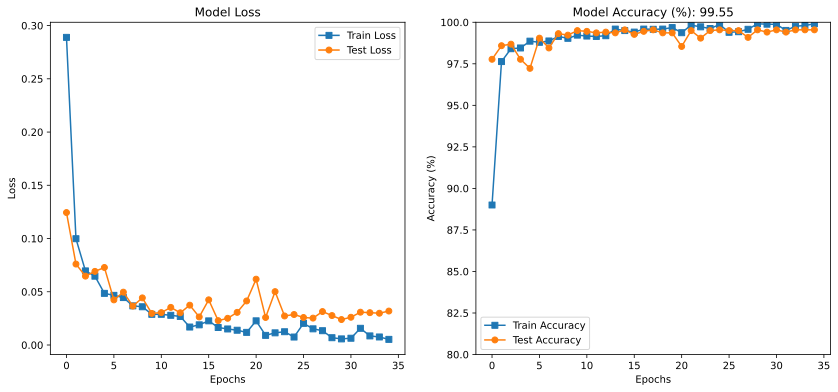

In [12]:
# Visualize the training and testing loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(trainLoss.cpu(), "s-", label="Train Loss")
axs[0].plot(testLoss.cpu(), "o-", label="Test Loss")
axs[0].set_title("Model Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(trainAcc.cpu(), "s-", label="Train Accuracy")
axs[1].plot(testAcc.cpu(), "o-", label="Test Accuracy")
axs[1].set_title(f"Model Accuracy (%): {testAcc[-1].cpu().item():.2f}")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_ylim(80, 100)
axs[0].legend()
axs[1].legend()

plt.show()

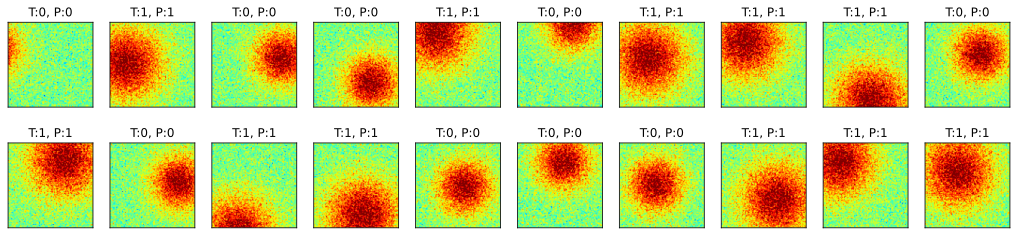

In [13]:
# Visualize some images
X, y = next(iter(test_loader))
yHat = net(X)

fig, axs = plt.subplots(2, 10, figsize=(18, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).cpu().detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap="jet")
    t = (int(y[i].item()), int(yHat[i].cpu().item() > 0))
    ax.set_title("T:%s, P:%s" % t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [14]:
# look at the filters
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(" ")
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2904, out_features=100, bias=True)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([4, 1, 3, 3])
torch.Size([6, 4, 3, 3])


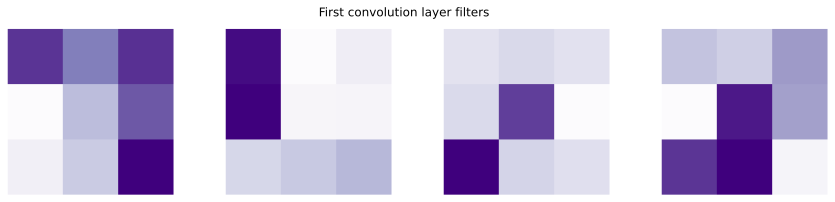

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(layer1W[i, :, :, :]).cpu().detach(), cmap="Purples")
    ax.axis("off")

plt.suptitle("First convolution layer filters")
plt.show()

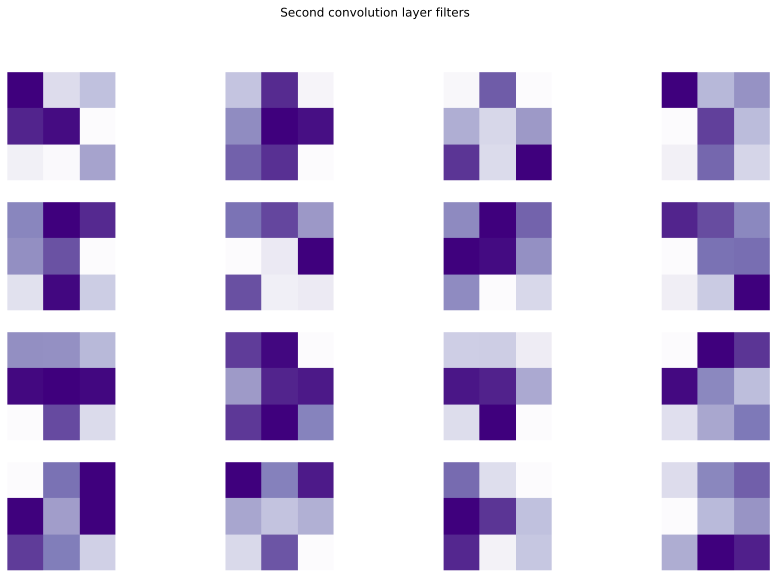

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(15, 9))

for i in range(4 * 4):
    idx = np.unravel_index(i, (4, 4))
    axs[idx].imshow(
        torch.squeeze(layer3W[idx[0], idx[1], :, :]).cpu().detach(), cmap="Purples"
    )
    axs[idx].axis("off")

plt.suptitle("Second convolution layer filters")
plt.show()

torch.Size([10, 91, 91]) torch.Size([10]) torch.Size([10])


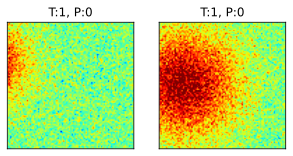

In [17]:
# 2) Find and plot the stimuli that the model guessed incorrectly. Is the correct answer obvious to you? Do the errors
#    tend to be obscured by the boundaries of the image, or is there any other reason you can find for why the model got
#    those wrong?
# Visualize Error images
X, y = next(iter(test_loader))
yHat = (net(X) > 0).float()
error = yHat != y
y = y[error]
yHat = yHat[error]
print(X[error].shape, yHat.shape, y.shape)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).cpu().detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap="jet")
    t = (int(y[i].item()), int(yHat[i].cpu().item() > 0))
    ax.set_title("T:%s, P:%s" % t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()